In [ ]:
import numpy as np
import os
import random

import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import entropy
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error, precision_recall_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import CalibrationError

from models.wide_resnet import Wide_ResNet
from multi_output_module.multi_output_module import Multi_output_module

In [ ]:
class RandomSeverityAugMix:
    def __init__(self, min_severity=1, max_severity=5, prob=0.7, mixture_width=3, chain_depth=-1, alpha=1.0, all_ops=True, interpolation=InterpolationMode.BILINEAR, fill=None):
        self.min_severity = min_severity
        self.max_severity = max_severity
        self.prob = prob  # Probability of applying AugMix
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth
        self.alpha = alpha
        self.all_ops = all_ops
        self.interpolation = interpolation
        self.fill = fill

    def __call__(self, img):
        if random.random() < self.prob:
            severity = random.randint(self.min_severity, self.max_severity)
            
            augmix_transform = transforms.AugMix(
                severity=severity,
                mixture_width=self.mixture_width,
                chain_depth=self.chain_depth,
                alpha=self.alpha,
                all_ops=self.all_ops,
                interpolation=self.interpolation,
                fill=self.fill
            )
            
            img = augmix_transform(img)
        
        return img

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 100

# Paths and batch size
data_path = './data'
batch_size = 32

transform_cifar100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
'''
val_transform_cifar100 = transforms.Compose([
    RandomSeverityAugMix(min_severity=1, max_severity=10, prob=0.8),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
'''
total_train_dataset = torchvision.datasets.CIFAR100(root=data_path, train=True, download=False, transform=transform_cifar100)
test_dataset = torchvision.datasets.CIFAR100(root=data_path, train=False, download=False, transform=transform_cifar100)

train_size = int(0.9 * len(total_train_dataset))
val_size = len(total_train_dataset) - train_size
train_dataset, val_dataset = random_split(total_train_dataset, [train_size, val_size])

#train_dataset.transform = val_transform_cifar100
#val_dataset.dataset.transform = val_transform_cifar100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the CIFAR-10 dataset as OOD
cifar10_ood_dataset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform_cifar10)

cifar10_ood_loader = DataLoader(cifar10_ood_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the transformations for the FashionMNIST dataset, converting grayscale to RGB (OOD)
transform_fashion = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel RGB
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing for RGB
])

# Load the FashionMNIST dataset as OOD
fashion_ood_dataset = torchvision.datasets.FashionMNIST(root=data_path, train=False, download=True, transform=transform_fashion)
fashion_ood_loader = DataLoader(fashion_ood_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [4]:
print("Training Dataset Transform:", total_train_dataset.transform)
print("Validation Dataset Transform:", val_dataset.dataset.transform)
print("Test Dataset Transform:", test_dataset.transform)

Training Dataset Transform: Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
Validation Dataset Transform: Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
Test Dataset Transform: Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loader Images:


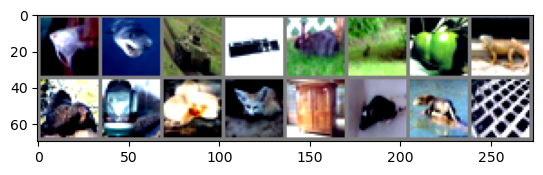

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation Loader Images:


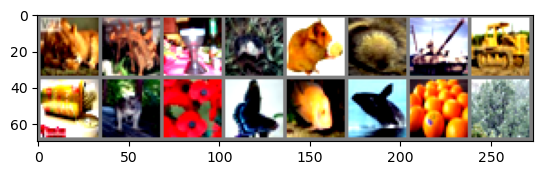

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Load a few images from train and validation loaders
dataiter_train = iter(train_loader)
images_train, _ = next(dataiter_train)

dataiter_val = iter(val_loader)
images_val, _ = next(dataiter_val)

print("Train Loader Images:")
imshow(torchvision.utils.make_grid(images_train[:16]))

print("Validation Loader Images:")
imshow(torchvision.utils.make_grid(images_val[:16]))

In [ ]:
cifar100_c_path = './data/CIFAR-100-C'  # Path to the CIFAR-100-C data
batch_size = 32

# Define the transformations for the CIFAR-100 dataset (same as original CIFAR-100)
transform_cifar100_c = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Same normalization as CIFAR-100
])

# Custom dataset class for CIFAR-100-C
class CIFAR100CDataset(Dataset):
    def __init__(self, corruption_type, data_path, transform=None):
        """
        Args:
            corruption_type (str): Name of the corruption (e.g., 'brightness', 'gaussian_noise').
            data_path (str): Path to the CIFAR-100-C dataset folder.
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.data_path = data_path
        self.corruption_type = corruption_type
        self.transform = transform
        
        # Load the corrupted images and labels
        self.images = np.load(os.path.join(data_path, f"{corruption_type}.npy"))
        self.labels = np.load(os.path.join(data_path, "labels.npy"))
        
        assert self.images.shape[0] == self.labels.shape[0], "Mismatch between number of images and labels."
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert image to PIL Image for transform compatibility
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create a DataLoader for each corruption type in CIFAR-100-C
corruption_types = ['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 
                    'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 
                    'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 
                    'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']

# Create DataLoaders for each corruption type
cifar100_c_loaders = {}
for corruption_type in corruption_types:
    cifar100_c_dataset = CIFAR100CDataset(corruption_type, cifar100_c_path, transform=transform_cifar100_c)
    cifar100_c_loader = DataLoader(cifar100_c_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    cifar100_c_loaders[corruption_type] = cifar100_c_loader

In [ ]:
base_model = Wide_ResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=num_classes)
base_model.load_state_dict(torch.load('./models/saved_models/cifar/cifar100/wide-resnet-28x10.pth'))

if torch.cuda.is_available():
    base_model = base_model.cuda()

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

accuracy = test(base_model, device, test_loader)
print(f'Reloaded model test accuracy: {accuracy:.2f}%')

Test set: Average loss: 1.0548, Accuracy: 7375/10000 (73.75%)

Reloaded model test accuracy: 73.75%


In [7]:
num_heads = 10
batch_size = 16
num_classes = 100

In [8]:
base_model.eval()
    
module = Multi_output_module(num_heads, base_model, device).to(device)
print(module)

#optimizer = optim.Adam(module.parameters(), lr=0.0008, weight_decay= 0.0005)

optimizer = optim.Adam(module.parameters(), lr=0.0001, weight_decay=0.0005)

criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size*num_heads, 
    shuffle=True, 
    drop_last=True,
    )


Multi_output_module(
  (activation): ReLU()
  (base_model): Wide_ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): Sequential(
      (0): wide_basic(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout(p=0.3, inplace=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Sequential(
          (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): wide_basic(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout(p=0.3, inplace=False)
        (bn2): BatchNo

In [9]:
total_params = sum(p.numel() for p in module.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 39189980


In [ ]:
# Early stopping parameters
patience = 5
best_loss = float('inf')
epochs_no_improve = 0
num_epochs = 200  # Set a high number of epochs

#optimizer = optim.Adam(module.parameters(), lr=0.00001, weight_decay=0)

step = 0
for epoch in range(num_epochs):
    module.train()

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        step += 1

        #step = batch_idx + len(train_loader)*epoch+1

        # Ensure labels are correctly shaped
        labels = labels.view(-1, num_heads)

        optimizer.zero_grad()
        predictions = module(images, 'training')

        # Compute loss for each output head and sum them
        total_loss = 0
        for i in range(num_heads):
            total_loss += criterion(predictions[:, i, :], labels[:, i])
        total_loss /= num_heads
        
        total_loss.backward()
        optimizer.step()

        loss = total_loss.item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss:.6f}")

    module.eval()
    val_loss = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            predictions = module(images, 'inference')
            
            mimo_output_avg = predictions.mean(dim=1)
            val_loss += criterion(mimo_output_avg, labels).item()
            _, predicted = torch.max(mimo_output_avg, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / total
    print(f'Epoch {epoch}, Val Loss: {val_loss:.6f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)')

    '''
    wandb.log({
        "Iter step": step,
        "valid/accs": accuracy,
        #"test/accs": test_accs_b,
        #"valid/best_acc": self.best_valid_acc_b,
        #"test/best_acc": self.best_test_acc_b,
    })
    '''

    # Check for early stopping based on test loss
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        best_model_state = module.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Load the best model state
module.load_state_dict(best_model_state)

#wandb_switch('Multi output module', 'First run', 0, 'finish')

Train Epoch: 0 [0/45000 (0%)]	Loss: 4.759672
Train Epoch: 0 [16000/45000 (36%)]	Loss: 4.591570
Train Epoch: 0 [32000/45000 (71%)]	Loss: 4.478639
Epoch 0, Val Loss: 0.076465, Accuracy: 4994/5000 (99.88%)
Train Epoch: 1 [0/45000 (0%)]	Loss: 4.486479
Train Epoch: 1 [16000/45000 (36%)]	Loss: 4.335126
Train Epoch: 1 [32000/45000 (71%)]	Loss: 4.195526
Epoch 1, Val Loss: 0.060893, Accuracy: 4989/5000 (99.78%)
Train Epoch: 2 [0/45000 (0%)]	Loss: 3.899426
Train Epoch: 2 [16000/45000 (36%)]	Loss: 3.633642
Train Epoch: 2 [32000/45000 (71%)]	Loss: 3.548529
Epoch 2, Val Loss: 0.043916, Accuracy: 4991/5000 (99.82%)
Train Epoch: 3 [0/45000 (0%)]	Loss: 3.391680
Train Epoch: 3 [16000/45000 (36%)]	Loss: 3.126467
Train Epoch: 3 [32000/45000 (71%)]	Loss: 2.837040
Epoch 3, Val Loss: 0.030678, Accuracy: 4989/5000 (99.78%)
Train Epoch: 4 [0/45000 (0%)]	Loss: 2.615518
Train Epoch: 4 [16000/45000 (36%)]	Loss: 2.582341
Train Epoch: 4 [32000/45000 (71%)]	Loss: 2.500010
Epoch 4, Val Loss: 0.021729, Accuracy: 4992

<All keys matched successfully>

In [47]:
train_dataset.transform = transform_cifar100

# Create data loaders for CIFAR-100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
'''
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pairwise_cosine_similarity_matrices(module, device, test_loader, class_label, sample_size=10):
    module.eval()
    outputs_list = []
    count = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            mask = labels == class_label
            if not torch.any(mask):
                continue

            images, labels = images[mask], labels[mask]
            predictions = module(images, 'inference')
            outputs = predictions.view(-1, module.num_heads, module.num_classes)
            outputs_list.append(outputs.cpu())
            count += outputs.size(0)

            if count >= sample_size:
                break

    if len(outputs_list) == 0:
        print(f"No samples found for class {class_label}.")
        return

    outputs_tensor = torch.cat(outputs_list, dim=0)

    if count > sample_size:
        indices = torch.randperm(count)[:sample_size]
        outputs_tensor = outputs_tensor[indices]

    # Calculate pairwise cosine similarity matrices
    cosine_matrix_12 = cosine_similarity(outputs_tensor[:, 0, :].numpy(), outputs_tensor[:, 1, :].numpy())
    cosine_matrix_13 = cosine_similarity(outputs_tensor[:, 0, :].numpy(), outputs_tensor[:, 2, :].numpy())
    cosine_matrix_23 = cosine_similarity(outputs_tensor[:, 1, :].numpy(), outputs_tensor[:, 2, :].numpy())

    # Plotting the cosine similarity matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(cosine_matrix_12, annot=True, cmap='coolwarm', ax=axes[0])
    axes[0].set_title('Cosine Similarity: Head 1 vs Head 2')
    axes[0].set_xlabel('Sample Index (Head 2)')
    axes[0].set_ylabel('Sample Index (Head 1)')

    sns.heatmap(cosine_matrix_13, annot=True, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Cosine Similarity: Head 1 vs Head 3')
    axes[1].set_xlabel('Sample Index (Head 3)')
    axes[1].set_ylabel('Sample Index (Head 1)')

    sns.heatmap(cosine_matrix_23, annot=True, cmap='coolwarm', ax=axes[2])
    axes[2].set_title('Cosine Similarity: Head 2 vs Head 3')
    axes[2].set_xlabel('Sample Index (Head 3)')
    axes[2].set_ylabel('Sample Index (Head 2)')

    plt.tight_layout()
    plt.show()

plot_pairwise_cosine_similarity_matrices(module, device, test_loader, class_label=80, sample_size=10)
'''

'\nimport torch\nimport torch.nn.functional as F\nfrom sklearn.metrics.pairwise import cosine_similarity\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ndef plot_pairwise_cosine_similarity_matrices(module, device, test_loader, class_label, sample_size=10):\n    module.eval()\n    outputs_list = []\n    count = 0\n\n    with torch.no_grad():\n        for images, labels in test_loader:\n            images, labels = images.to(device), labels.to(device)\n\n            mask = labels == class_label\n            if not torch.any(mask):\n                continue\n\n            images, labels = images[mask], labels[mask]\n            predictions = module(images, \'inference\')\n            outputs = predictions.view(-1, module.num_heads, module.num_classes)\n            outputs_list.append(outputs.cpu())\n            count += outputs.size(0)\n\n            if count >= sample_size:\n                break\n\n    if len(outputs_list) == 0:\n        print(f"No samples found for class {cl

CIFAR10 Train set:
Average Entropy for Base Model Outputs: 0.0074
Average Entropy for Multi Outputs: 0.1139
CIFAR10 Test set:
Average Entropy for Base Model Outputs: 0.2904
Average Entropy for Multi Outputs: 0.7582
FashionMNIST OOD set:
Average Entropy for Base Model Outputs: 1.1180
Average Entropy for Multi Outputs: 2.1890
CIFAR100 OOD set:
Average Entropy for Base Model Outputs: 0.8668
Average Entropy for Multi Outputs: 1.9048


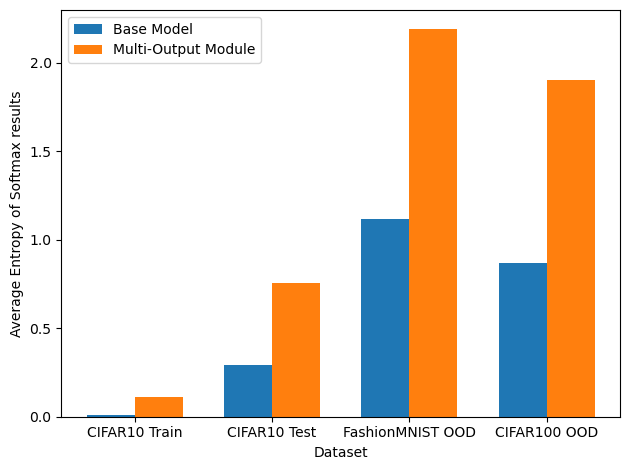

In [ ]:
# Function to compute and print the mean entropy of softmax outputs for base_model and module
def compute_mean_entropy_of_mean_softmax(loader, base_model, module, device):
    base_model.eval()
    module.eval()

    total_base_entropy_sum = 0
    total_multi_output_entropy_sum = 0
    num_samples = 0

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            batch_size = images.size(0)
            num_samples += batch_size

            # Base model prediction and entropy calculation
            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()
            base_entropies = np.sum(entropy(base_output_softmax, axis=1))
            total_base_entropy_sum += base_entropies

            # Repeat and reshape images for the multi-output module
            multi_output_predictions = module(images, 'inference')
            multi_output_avg = multi_output_predictions.mean(dim=1).cpu().numpy()
            multi_output_softmax = F.softmax(torch.tensor(multi_output_avg), dim=1).numpy()
            multi_output_entropy = np.sum(entropy(multi_output_softmax, axis=1))
            total_multi_output_entropy_sum += multi_output_entropy

    average_base_entropy = total_base_entropy_sum / num_samples
    average_multi_output_entropy = total_multi_output_entropy_sum / num_samples

    print(f"Average Entropy for Base Model Outputs: {average_base_entropy:.4f}")
    print(f"Average Entropy for Multi Outputs: {average_multi_output_entropy:.4f}")

    return average_base_entropy, average_multi_output_entropy


print("CIFAR10 Train set:")
train_base_entropy, train_multi_output_entropy = compute_mean_entropy_of_mean_softmax(train_loader, base_model, module, device)
print("CIFAR10 Test set:")
test_base_entropy, test_multi_output_entropy = compute_mean_entropy_of_mean_softmax(test_loader, base_model, module, device)
print("FashionMNIST OOD set:")
fashion_base_entropy, fashion_multi_output_entropy = compute_mean_entropy_of_mean_softmax(fashion_ood_loader, base_model, module, device)
print("CIFAR100 OOD set:")
cifar100_base_entropy, cifar100_multi_output_entropy = compute_mean_entropy_of_mean_softmax(cifar10_ood_loader, base_model, module, device)

labels = ['CIFAR10 Train', 'CIFAR10 Test', 'FashionMNIST OOD', 'CIFAR100 OOD']
base_entropies = [train_base_entropy, test_base_entropy, fashion_base_entropy, cifar100_base_entropy]
multi_output_entropies = [train_multi_output_entropy, test_multi_output_entropy, fashion_multi_output_entropy, cifar100_multi_output_entropy]

x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, base_entropies, width, label='Base Model')
rects2 = ax.bar(x + width/2, multi_output_entropies, width, label='Multi-Output Module')

ax.set_xlabel('Dataset')
ax.set_ylabel('Average Entropy of Softmax results')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
def compute_mce(predictions, confidences, labels, n_bins=15):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    mce = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = [(conf >= bin_lower) and (conf < bin_upper) for conf in confidences]
        if np.any(in_bin):
            accuracy_in_bin = np.mean([pred == label for pred, label, inb in zip(predictions, labels, in_bin) if inb])
            avg_confidence_in_bin = np.mean([conf for conf, inb in zip(confidences, in_bin) if inb])
            mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))
    return mce

def compute_calibration_metrics(loader, base_model, module, device):
    base_model.eval()
    module.eval()

    # Base Model Metrics
    base_correct = 0
    base_total = 0
    base_test_loss = 0.0

    # Multi-output Module Metrics
    multi_output_correct = 0
    multi_output_total = 0
    multi_output_test_loss = 0.0

    # Initialize calibration metrics
    base_ece_metric = CalibrationError(n_bins=15, task="multiclass", num_classes=100).to(device)
    multi_output_ece_metric = CalibrationError(n_bins=15, task="multiclass", num_classes=100).to(device)

    # Variables to accumulate all labels, softmax outputs, and confidences
    base_all_labels = []
    base_all_softmax_outputs = []
    base_all_confidences = []
    base_all_predictions = []

    multi_output_all_labels = []
    multi_output_all_softmax_outputs = []
    multi_output_all_confidences = []
    multi_output_all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Base model predictions and logits collection
            base_outputs = base_model(images)
            base_test_loss += F.cross_entropy(base_outputs, labels, reduction='sum').item()
            base_preds = base_outputs.argmax(dim=1, keepdim=True)
            base_correct += base_preds.eq(labels.view_as(base_preds)).sum().item()
            base_total += labels.size(0)

            # Calculate metrics for base model
            base_softmax_outputs = F.softmax(base_outputs, dim=1)
            base_ece_metric.update(base_softmax_outputs, labels)

            # Accumulate labels, softmax outputs, confidences, and predictions for base model
            base_all_labels.extend(labels.cpu().numpy())
            base_all_softmax_outputs.extend(base_softmax_outputs.cpu().numpy())
            base_all_confidences.extend(base_softmax_outputs.max(dim=1)[0].cpu().numpy())
            base_all_predictions.extend(base_preds.cpu().numpy())

            # Multi-output module predictions and logits collection
            multi_output_predictions = module(images, 'inference')

            # Apply softmax to each head's output and then average the probabilities
            multi_output_softmax = F.softmax(multi_output_predictions, dim=-1)
            multi_output_avg = multi_output_softmax.mean(dim=1)
            
            multi_output_test_loss += F.cross_entropy(multi_output_avg, labels, reduction='sum').item()
            multi_output_preds = multi_output_avg.argmax(dim=1, keepdim=True)
            multi_output_correct += multi_output_preds.eq(labels.view_as(multi_output_preds)).sum().item()
            multi_output_total += labels.size(0)

            # Calculate metrics for multi-output module
            multi_output_ece_metric.update(multi_output_avg, labels)

            # Accumulate labels, softmax outputs, confidences, and predictions for multi-output module
            multi_output_all_labels.extend(labels.cpu().numpy())
            multi_output_all_softmax_outputs.extend(multi_output_avg.cpu().numpy())
            multi_output_all_confidences.extend(multi_output_avg.max(dim=1)[0].cpu().numpy())
            multi_output_all_predictions.extend(multi_output_preds.cpu().numpy())

    # Calculate base model final accuracy and metrics
    base_accuracy = 100. * base_correct / base_total
    base_test_loss /= base_total
    base_ece = base_ece_metric.compute().item()

    # Ensure that softmax outputs sum to one before calculating NLL and Brier score
    base_all_softmax_outputs = np.array(base_all_softmax_outputs)
    base_all_softmax_outputs /= base_all_softmax_outputs.sum(axis=1, keepdims=True)
    base_nll = log_loss(base_all_labels, base_all_softmax_outputs)
    base_brier = mean_squared_error(F.one_hot(torch.tensor(base_all_labels), num_classes=100).numpy(), base_all_softmax_outputs)
    base_mce = compute_mce(base_all_predictions, base_all_confidences, base_all_labels)

    # Calculate multi-output module final accuracy and metrics
    multi_output_accuracy = 100. * multi_output_correct / multi_output_total
    multi_output_test_loss /= multi_output_total
    multi_output_ece = multi_output_ece_metric.compute().item()

    multi_output_all_softmax_outputs = np.array(multi_output_all_softmax_outputs)
    multi_output_all_softmax_outputs /= multi_output_all_softmax_outputs.sum(axis=1, keepdims=True)
    multi_output_nll = log_loss(multi_output_all_labels, multi_output_all_softmax_outputs)
    multi_output_brier = mean_squared_error(F.one_hot(torch.tensor(multi_output_all_labels), num_classes=100).numpy(), multi_output_all_softmax_outputs)
    multi_output_mce = compute_mce(multi_output_all_predictions, multi_output_all_confidences, multi_output_all_labels)

    print(f"Base Model Accuracy: {base_accuracy:.2f}%, Brier Score: {base_brier:.4f}, NLL: {base_nll:.4f}, ECE: {base_ece:.4f}, MCE: {base_mce:.4f}")
    print(f"Multi-Output Module Accuracy: {multi_output_accuracy:.2f}%, Brier Score: {multi_output_brier:.4f}, NLL: {multi_output_nll:.4f}, ECE: {multi_output_ece:.4f}, MCE: {multi_output_mce:.4f}")

    return {
        "Base Model": {
            "Test NLL": base_nll,
            "Test Accuracy": base_accuracy,
            "Test Cal. Error": base_ece,
            "Test Brier Score": base_brier,
            "Test MCE": base_mce,
        },
        "Multi-Output Module": {
            "Test NLL": multi_output_nll,
            "Test Accuracy": multi_output_accuracy,
            "Test Cal. Error": multi_output_ece,
            "Test Brier Score": multi_output_brier,
            "Test MCE": multi_output_mce,
        }
    }

accuracy_metrics = compute_calibration_metrics(test_loader, base_model, module, device)

Base Model Accuracy: 78.11%, Brier Score: 0.0034, NLL: 1.0930, ECE: 0.1241, MCE: 0.3172
Multi-Output Module Accuracy: 77.49%, Brier Score: 0.0031, NLL: 0.8502, ECE: 0.0271, MCE: 0.0797


In [ ]:
def compute_mce(predictions, confidences, labels, n_bins=15):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    mce = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = [(conf >= bin_lower) and (conf < bin_upper) for conf in confidences]
        if np.any(in_bin):
            accuracy_in_bin = np.mean([pred == label for pred, label, inb in zip(predictions, labels, in_bin) if inb])
            avg_confidence_in_bin = np.mean([conf for conf, inb in zip(confidences, in_bin) if inb])
            mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))
    return mce

# Compute metrics for corrupted CIFAR-100 dataset
def compute_corruption_metrics(c_loader, base_model, module, device, num_classes=100, n_bins=15):
    base_model.eval()
    module.eval()

    # Initialize variables to store the corrupted metrics
    base_cA, base_cECE, base_cBrier, base_cMCE, base_cNLL = [], [], [], [], []
    multi_output_cA, multi_output_cECE, multi_output_cBrier, multi_output_cMCE, multi_output_cNLL = [], [], [], [], []

    # Iterate over all corruption types
    for corruption, loader in c_loader.items():
        base_correct, base_total, base_test_loss = 0, 0, 0.0
        multi_output_correct, multi_output_total, multi_output_test_loss = 0, 0, 0.0

        # Initialize calibration metrics (ECE)
        base_ece_metric = CalibrationError(n_bins=n_bins, task="multiclass", num_classes=num_classes).to(device)
        multi_output_ece_metric = CalibrationError(n_bins=n_bins, task="multiclass", num_classes=num_classes).to(device)

        # Variables to accumulate predictions, labels, and softmax outputs
        base_all_labels, base_all_softmax_outputs, base_all_confidences, base_all_predictions = [], [], [], []
        multi_output_all_labels, multi_output_all_softmax_outputs, multi_output_all_confidences, multi_output_all_predictions = [], [], [], []

        # Iterate over the corrupted dataset (for each severity level within the corruption)
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)

                # Base model predictions
                base_outputs = base_model(images)
                base_test_loss += F.cross_entropy(base_outputs, labels, reduction='sum').item()
                base_preds = base_outputs.argmax(dim=1, keepdim=True)
                base_correct += base_preds.eq(labels.view_as(base_preds)).sum().item()
                base_total += labels.size(0)

                base_softmax_outputs = F.softmax(base_outputs, dim=1)
                base_ece_metric.update(base_softmax_outputs, labels)

                base_all_labels.extend(labels.cpu().numpy())
                base_all_softmax_outputs.extend(base_softmax_outputs.cpu().numpy())
                base_all_confidences.extend(base_softmax_outputs.max(dim=1)[0].cpu().numpy())
                base_all_predictions.extend(base_preds.cpu().numpy())

                # Multi-output module predictions
                multi_output_predictions = module(images, 'inference')
                multi_output_softmax = F.softmax(multi_output_predictions, dim=-1)
                multi_output_avg = multi_output_softmax.mean(dim=1)

                multi_output_test_loss += F.cross_entropy(multi_output_avg, labels, reduction='sum').item()
                multi_output_preds = multi_output_avg.argmax(dim=1, keepdim=True)
                multi_output_correct += multi_output_preds.eq(labels.view_as(multi_output_preds)).sum().item()
                multi_output_total += labels.size(0)

                multi_output_ece_metric.update(multi_output_avg, labels)

                multi_output_all_labels.extend(labels.cpu().numpy())
                multi_output_all_softmax_outputs.extend(multi_output_avg.cpu().numpy())
                multi_output_all_confidences.extend(multi_output_avg.max(dim=1)[0].cpu().numpy())
                multi_output_all_predictions.extend(multi_output_preds.cpu().numpy())

        # Calculate base model metrics
        base_accuracy = 100. * base_correct / base_total
        base_test_loss /= base_total
        base_ece = base_ece_metric.compute().item()

        # Ensure labels are integers for F.one_hot
        base_all_labels = np.array(base_all_labels, dtype=np.int64)

        base_all_softmax_outputs = np.array(base_all_softmax_outputs)
        base_all_softmax_outputs /= base_all_softmax_outputs.sum(axis=1, keepdims=True)
        base_nll = log_loss(base_all_labels, base_all_softmax_outputs)
        base_brier = mean_squared_error(
            F.one_hot(torch.tensor(base_all_labels).long(), num_classes=num_classes).numpy(), 
            base_all_softmax_outputs
        )
        base_mce = compute_mce(base_all_predictions, base_all_confidences, base_all_labels)

        base_cA.append(base_accuracy)
        base_cNLL.append(base_nll)
        base_cECE.append(base_ece)
        base_cBrier.append(base_brier)
        base_cMCE.append(base_mce)

        # Calculate multi-output model metrics
        multi_output_accuracy = 100. * multi_output_correct / multi_output_total
        multi_output_test_loss /= multi_output_total
        multi_output_ece = multi_output_ece_metric.compute().item()

        multi_output_all_labels = np.array(multi_output_all_labels, dtype=np.int64)

        multi_output_all_softmax_outputs = np.array(multi_output_all_softmax_outputs)
        multi_output_all_softmax_outputs /= multi_output_all_softmax_outputs.sum(axis=1, keepdims=True)
        multi_output_nll = log_loss(multi_output_all_labels, multi_output_all_softmax_outputs)
        multi_output_brier = mean_squared_error(
            F.one_hot(torch.tensor(multi_output_all_labels).long(), num_classes=num_classes).numpy(), 
            multi_output_all_softmax_outputs
        )
        multi_output_mce = compute_mce(multi_output_all_predictions, multi_output_all_confidences, multi_output_all_labels)

        multi_output_cA.append(multi_output_accuracy)
        multi_output_cNLL.append(multi_output_nll)
        multi_output_cECE.append(multi_output_ece)
        multi_output_cBrier.append(multi_output_brier)
        multi_output_cMCE.append(multi_output_mce)

    # Take the mean across all corruption types
    return {
        "Base Model": {
            "cA": np.mean(base_cA),
            "cNLL": np.mean(base_cNLL),
            "cECE": np.mean(base_cECE),
            "cBrier": np.mean(base_cBrier),
            "cMCE": np.mean(base_cMCE),
        },
        "Multi-Output Module": {
            "cA": np.mean(multi_output_cA),
            "cNLL": np.mean(multi_output_cNLL),
            "cECE": np.mean(multi_output_cECE),
            "cBrier": np.mean(multi_output_cBrier),
            "cMCE": np.mean(multi_output_cMCE),
        }
    }

corrupted_metrics = compute_corruption_metrics(cifar100_c_loaders, base_model, module, device)
print(corrupted_metrics)

{'Base Model': {'cA': 44.955368421052626, 'cNLL': 4.264838289225167, 'cECE': 0.37894196965192495, 'cBrier': 0.008903123276999996, 'cMCE': 0.5605835605048768}, 'Multi-Output Module': {'cA': 46.22105263157895, 'cNLL': 2.5722578679136827, 'cECE': 0.11837036231238592, 'cBrier': 0.006982043580928121, 'cMCE': 0.2590157411262594}}


In [ ]:
def compute_ood_detection_metrics(train_loader, ood_loader, base_model, module, num_classes, num_heads, device):
    base_model.eval()
    module.eval()

    base_ind_scores = []
    base_ood_scores = []
    multi_output_ind_scores = []
    multi_output_ood_scores = []

    with torch.no_grad():
        # Process In-Distribution (ID) data
        for images, _ in train_loader:
            images = images.to(device)

            # Base model ID entropy
            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()
            base_entropy = entropy(base_output_softmax, axis=1)
            base_ind_scores.extend(base_entropy)

            # Multi-output module ID entropy
            multi_output_module_output = module(images, 'inference')
            multi_output_avg = multi_output_module_output.mean(dim=1)
            multi_output_softmax = F.softmax(multi_output_avg, dim=1).cpu().numpy()
            multi_output_entropy = entropy(multi_output_softmax, axis=1)
            multi_output_ind_scores.extend(multi_output_entropy)

        # Process Out-of-Distribution (OOD) data
        for images, _ in ood_loader:
            images = images.to(device)

            # Base model OOD entropy
            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()
            base_entropy = entropy(base_output_softmax, axis=1)
            base_ood_scores.extend(base_entropy)

            # Multi-output module OOD entropy
            multi_output_module_output = module(images, 'inference')
            multi_output_avg = multi_output_module_output.mean(dim=1)
            multi_output_softmax = F.softmax(multi_output_avg, dim=1).cpu().numpy()
            multi_output_entropy = entropy(multi_output_softmax, axis=1)
            multi_output_ood_scores.extend(multi_output_entropy)

    # Generating labels (0 for in-distribution, 1 for OOD)
    base_labels = np.concatenate([np.zeros(len(base_ind_scores)), np.ones(len(base_ood_scores))])
    base_scores = np.concatenate([base_ind_scores, base_ood_scores])
    base_auroc = roc_auc_score(base_labels, base_scores)

    multi_output_labels = np.concatenate([np.zeros(len(multi_output_ind_scores)), np.ones(len(multi_output_ood_scores))])
    multi_output_scores = np.concatenate([multi_output_ind_scores, multi_output_ood_scores])
    multi_output_auroc = roc_auc_score(multi_output_labels, multi_output_scores)

    # Compute AUR (Area Under Recall) for base model
    base_precision, base_recall, _ = precision_recall_curve(base_labels, base_scores)
    base_aur = np.trapz(base_recall, base_precision)  # AUR for base model

    # Compute AUPR (Area Under Precision-Recall Curve) for base model
    base_aupr = auc(base_recall, base_precision)  # AUPR for base model

    # Compute AUR for multi-output model
    multi_output_precision, multi_output_recall, _ = precision_recall_curve(multi_output_labels, multi_output_scores)
    multi_output_aur = np.trapz(multi_output_recall, multi_output_precision)  # AUR for multi-output model

    # Compute AUPR for multi-output model
    multi_output_aupr = auc(multi_output_recall, multi_output_precision)  # AUPR for multi-output model

    print(f"Base Model AUROC: {base_auroc:.4f}")
    print(f"Multi-Output Model AUROC: {multi_output_auroc:.4f}")
    print(f"Base Model AUR: {base_aur:.4f}")
    print(f"Multi-Output Model AUR: {multi_output_aur:.4f}")
    print(f"Base Model AUPR: {base_aupr:.4f}")
    print(f"Multi-Output Model AUPR: {multi_output_aupr:.4f}")

    return {
        "base_auroc": base_auroc,
        "multi_output_auroc": multi_output_auroc,
        "base_aur": base_aur,
        "multi_output_aur": multi_output_aur,
        "base_aupr": base_aupr,
        "multi_output_aupr": multi_output_aupr,
    }

print("Fashion OOD")
fashion_ood_metrics = compute_ood_detection_metrics(train_loader, fashion_ood_loader, base_model, module, num_classes, num_heads, device)

print("Cifar10 OOD")
cifar100_ood_metrics = compute_ood_detection_metrics(train_loader, cifar10_ood_loader, base_model, module, num_classes, num_heads, device)

In [ ]:
def compute_energy_score(logits):
    return -torch.logsumexp(logits, dim=1).cpu().numpy()

# Compute AUROC, AUPR, and AUR for OOD detection
def compute_metrics_for_scores(labels, scores):
    auroc = roc_auc_score(labels, scores)
    precision, recall, _ = precision_recall_curve(labels, scores)
    aupr = auc(recall, precision)
    aur = np.trapz(recall, precision)
    return auroc, aupr, aur

def compute_ood_detection_metrics(train_loader, ood_loader, base_model, module, num_classes, num_heads, device):
    base_model.eval()
    module.eval()

    # Store different metrics for base and multi-output models
    base_ind_metrics = {'entropy': [], 'msp': [], 'energy': []}
    base_ood_metrics = {'entropy': [], 'msp': [], 'energy': []}
    
    multi_output_ind_metrics = {'entropy': [], 'msp': [], 'energy': []}
    multi_output_ood_metrics = {'entropy': [], 'msp': [], 'energy': []}

    with torch.no_grad():
        # Process In-Distribution (ID) data
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Base model processing for ID
            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()

            base_entropy = entropy(base_output_softmax, axis=1)
            base_msp = np.max(base_output_softmax, axis=1)
            base_energy = compute_energy_score(base_outputs)

            base_ind_metrics['entropy'].extend(base_entropy)
            base_ind_metrics['msp'].extend(-base_msp)  # Invert MSP for OOD detection
            base_ind_metrics['energy'].extend(base_energy)

            # Multi-output model processing for ID
            multi_output_module_output = module(images, 'inference')
            multi_output_avg = multi_output_module_output.mean(dim=1)
            multi_output_softmax = F.softmax(multi_output_avg, dim=1).cpu().numpy()

            multi_output_entropy = entropy(multi_output_softmax, axis=1)
            multi_output_msp = np.max(multi_output_softmax, axis=1)
            multi_output_energy = compute_energy_score(multi_output_avg)

            multi_output_ind_metrics['entropy'].extend(multi_output_entropy)
            multi_output_ind_metrics['msp'].extend(-multi_output_msp)  # Invert MSP for OOD detection
            multi_output_ind_metrics['energy'].extend(multi_output_energy)

        # Process Out-of-Distribution (OOD) data
        for images, labels in ood_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Base model processing for OOD
            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()

            base_entropy = entropy(base_output_softmax, axis=1)
            base_msp = np.max(base_output_softmax, axis=1)
            base_energy = compute_energy_score(base_outputs)

            base_ood_metrics['entropy'].extend(base_entropy)
            base_ood_metrics['msp'].extend(-base_msp)  # Invert MSP for OOD detection
            base_ood_metrics['energy'].extend(base_energy)

            # Multi-output model processing for OOD
            multi_output_module_output = module(images, 'inference')
            multi_output_avg = multi_output_module_output.mean(dim=1)
            multi_output_softmax = F.softmax(multi_output_avg, dim=1).cpu().numpy()

            multi_output_entropy = entropy(multi_output_softmax, axis=1)
            multi_output_msp = np.max(multi_output_softmax, axis=1)
            multi_output_energy = compute_energy_score(multi_output_avg)

            multi_output_ood_metrics['entropy'].extend(multi_output_entropy)
            multi_output_ood_metrics['msp'].extend(-multi_output_msp)  # Invert MSP for OOD detection
            multi_output_ood_metrics['energy'].extend(multi_output_energy)

    # Generating labels (0 for in-distribution, 1 for OOD)
    base_labels = np.concatenate([np.zeros(len(base_ind_metrics['entropy'])), np.ones(len(base_ood_metrics['entropy']))])
    multi_output_labels = np.concatenate([np.zeros(len(multi_output_ind_metrics['entropy'])), np.ones(len(multi_output_ood_metrics['entropy']))])

    # Compute metrics for each method for base and multi-output models
    base_results = {}
    multi_output_results = {}

    for metric in ['entropy', 'msp', 'energy']:
        base_scores = np.concatenate([base_ind_metrics[metric], base_ood_metrics[metric]])
        multi_output_scores = np.concatenate([multi_output_ind_metrics[metric], multi_output_ood_metrics[metric]])

        base_results[metric] = compute_metrics_for_scores(base_labels, base_scores)
        multi_output_results[metric] = compute_metrics_for_scores(multi_output_labels, multi_output_scores)

    # Print results in array-like format
    print(f"{'Metric':<10} {'AUROC':<10} {'AUPR':<10} {'AUR':<10}")
    for metric in ['entropy', 'msp', 'energy']:
        print(f"Base {metric:<10} {base_results[metric][0]:<10.4f} {base_results[metric][1]:<10.4f} {base_results[metric][2]:<10.4f}")
        print(f"Multi {metric:<10} {multi_output_results[metric][0]:<10.4f} {multi_output_results[metric][1]:<10.4f} {multi_output_results[metric][2]:<10.4f}")

    return {
        "base_results": base_results,
        "multi_output_results": multi_output_results
    }

print("Fashion OOD")
fashion_ood_metrics = compute_ood_detection_metrics(train_loader, fashion_ood_loader, base_model, module, num_classes, num_heads, device)

print("Cifar10 OOD")
cifar100_ood_metrics = compute_ood_detection_metrics(train_loader, cifar10_ood_loader, base_model, module, num_classes, num_heads, device)


Fashion OOD
Metric     AUROC      AUPR       AUR       
Base entropy    0.9850     0.9545     0.7727    
Multi entropy    0.9919     0.9781     0.7963    
Base msp        0.9838     0.9469     0.7651    
Multi msp        0.9910     0.9746     0.7927    
Base energy     0.9913     0.9713     0.7895    
Multi energy     0.9786     0.9086     0.7268    
Cifar10 OOD


KeyboardInterrupt: 